In [77]:
#%load_ext autoreload
#%autoreload 2
# %matplotlib qt5
# %matplotlib inline

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import ticker
import numpy as np
import os
import math
import ipywidgets as widgets

from plot_helpers import *

import warnings
warnings.filterwarnings('ignore')

# pd.set_option('display.max_rows', 1000)

############## FIGURES ##############
# Generic plotting configurations
# plt.rcParams['figure.figsize'] = [10, 6]
# plt.rcParams['pdf.fonttype'] = 42
# plt.rcParams['ps.fonttype'] = 42

# plt.style.use('ggplot')
plt.style.use(['ggplot'])
plt.rcParams['figure.dpi'] = 130
# plt.rcParams['figure.figsize'] = [2.12, 1.6]

def xm(x):
    return np.array([x,   1])
def ym(y):
    return np.array([1,   y])

default  = np.array([3.3,   2.5])
double   = np.array([6.6,   5])
tlwidth  = np.array([1.58, 2.5])
hlwidth  = np.array([2.375, 2.5])
flwidth  = np.array([4.75,  2.5])
fl22  = np.array([4.75,  2])
flhh  = np.array([4.75,  1.25])

figfolder = 'plots'

############### Experiment selection ###################

EXP_list = [exp_folder.split('/')[-1] for exp_folder in sorted(glob.glob('%s/*' % datadir))]
CFG_dict = {exp: [cfg_folder.split('/')[-2] for cfg_folder in sorted(glob.glob('%s/%s/*/' % (datadir, exp)))] for exp in EXP_list}
REP_dict = {exp+'/'+cfg: [rep_folder.split('/')[-2] for rep_folder in sorted(glob.glob('%s/%s/%s/*/' % (datadir, exp, cfg)))] for exp in EXP_list for cfg in CFG_dict[exp]} 

EXP_drop = widgets.Dropdown(
    options=EXP_list,
    value=EXP_list[-1],
    description='Exp:',
    disabled=False,
)

EXP_multiple = widgets.SelectMultiple(
    options=EXP_list,
    value=[EXP_list[-1]],
    description='Exp:',
    disabled=False,
)

CFG_drop    = widgets.Dropdown(description='Cfg:',options=['all'], value = 'all', disabled=False)
REP_drop    = widgets.Dropdown(description='Rep:',options=['all'], value = 'all', disabled=False)
LOAD_button = widgets.Button(description='Load Exp')
CONF_button = widgets.Button(description='See Config')

global df_exp
global logfile
global loaded
loaded = ('','')

def on_load_button_clicked(b):
    global df_exp, logfile, loaded
    
    df_exp = create_df(EXP_drop.value, logfile)
    loaded = (EXP_drop.value, logfile)
    print('Loaded dataframe: %s // datafile: %s' % loaded)

def on_conf_button_clicked(b):
    global df_exp, logfile, loaded
    
    get_config_dicts(EXP_drop.value, CFG_drop.value, REP_drop.value)
    
def on_change_exp(change):

    if change['name'] == 'value':
        CFG_drop.options = ['all']+CFG_dict[EXP_drop.value]
        if CFG_drop.value == 'all':
            REP_drop.options = ['all']
        else:
            REP_drop.options = ['all']+REP_dict[EXP_drop.value+'/'+CFG_drop.value]
        
def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        CFG_drop.options = ['all']+CFG_dict[EXP_drop.value]
        if CFG_drop.value == 'all':
            REP_drop.options = ['all']
        else:
            REP_drop.options = ['all']+REP_dict[EXP_drop.value+'/'+CFG_drop.value]
              
EXP_drop.observe(on_change)
CFG_drop.observe(on_change)
LOAD_button.on_click(on_load_button_clicked)
CONF_button.on_click(on_conf_button_clicked)

def load_df(lf):
    global df_exp
    global logfile
    global loaded
    
    logfile = lf
    
    # Select which experiment to plot the whole blockchain
    grid = widgets.GridspecLayout(3,2)
    grid[0,0] = EXP_drop
    grid[1,0] = CFG_drop
    grid[2,0] = REP_drop
    grid[1,1] = LOAD_button
    grid[2,1] = CONF_button
    display(grid)
    
    if loaded != (EXP_drop.value, logfile):
        LOAD_button.click()
        on_change({'type':'change', 'name':'value'})
    df = df_exp
    
    if CFG_drop.value != 'all':
        df = df.query("CFG in @CFG_drop.value")

    if REP_drop.value != 'all':
        df = df.query("REP in @REP_drop.value")
    return df

## Automatically default the dataset to most recently changed
# all_subdirs = ['data/'+d for d in os.listdir('data/') if d.startswith('experiment')]
# latest_subdir = max(all_subdirs, key=os.path.getmtime)
# EXP_drop.value = latest_subdir.split('experiment_')[-1]


Loaded dataframe: test // datafile: cluster


In [13]:
display(EXP_multiple)
EXP = EXP_multiple.value
print(EXP)

SelectMultiple(description='Exp:', index=(0,), options=('test',), value=('test',))

('test',)


## Time elapsed between blocks (histogram)

SelectMultiple(description='Exp:', index=(0,), options=('test1',), value=('test1',))

Experiment datasets: test1


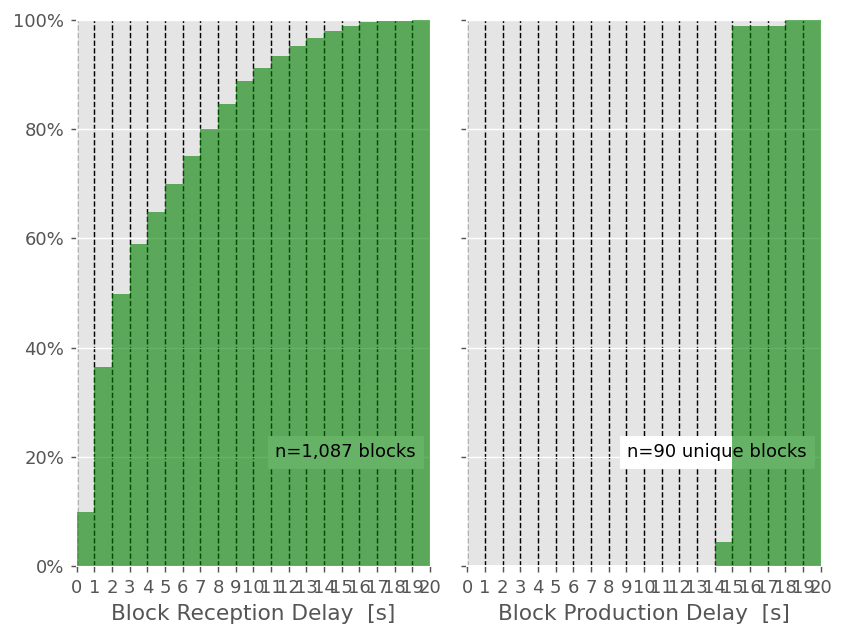

In [2]:
display(EXP_multiple)
EXP = EXP_multiple.value
print('Experiment datasets: '+','.join(EXP))

# Generate the dataframe
df = create_df(EXP, 'block')
# display(df)
# df = df.get_param(df,'generic_params','block_period')
XMAX = 20

###############################################################
# Process the dataframe  
bins = range(0, XMAX+1, 1)

# Create figure
fig, ax = plt.subplots(1,2, sharey=True, figsize=double)

# Create plot
hist, bins = np.histogram(df['TELAPSED'], bins=bins)
ax[0].bar(bins[:-1]+(bins[1]-bins[0])/2, 
          np.cumsum(hist.astype(np.float32))/hist.sum(), 
          width =(bins[1]-bins[0]), 
          color ='green', 
          alpha = 0.6,
          zorder= 3)
# ax = df['TELAPSED'].plot.hist(color='green', bins=bins, xticks=xticks)

# Edit plot
ax[0].grid(axis='x', linestyle='--', color='k',zorder=1) 
ax[0].text(XMAX-0.8,0.2,'n=%s blocks' % format(len(df), ',d'),ha='right',zorder=4)
t = ax[0].text(XMAX-0.8,0.2,'n=%s blocks' % format(len(df), ',d'),ha='right',color='white',zorder=2)
t.set_bbox(dict(facecolor='white', edgecolor='white'))
ax[0].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
ax[0].set_ylim(ymin=0, ymax = 1)
ax[0].set_xticks(bins)
ax[0].set_xlim(xmin=bins[0], xmax = bins[-1])
ax[0].set_xlabel('Block Reception Delay  [s]')

###############################################################
# Process the dataframe  
df = df.drop_duplicates('HASH')
df = trim_chain(df, 10).sort_values('TIMESTAMP')
df['TPROD'] = df.groupby(['EXP', 'REP'])['TIMESTAMP'].diff(1)

# Create plot
hist, bins = np.histogram(df['TPROD'], bins=bins)
ax[1].bar(bins[:-1]+(bins[1]-bins[0])/2, 
          np.cumsum(hist.astype(np.float32))/hist.sum(), 
          width =(bins[1]-bins[0]), 
          color ='green', 
          alpha = 0.6,
          zorder=3)
# ax = df['TPROD'].plot.hist(color='green', bins=bins, xticks=xticks)

# Edit plot
ax[1].grid(axis='x', linestyle='--', color='k',zorder=1) 
ax[1].text(XMAX-0.8,0.2,'n=%s unique blocks' % format(len(df), ',d'),ha='right',zorder=4)
t = ax[1].text(XMAX-0.8,0.2,'n=%s unique blocks' % format(len(df), ',d'),ha='right',color='white',zorder=2)
t.set_bbox(dict(facecolor='white', edgecolor='white'))
ax[1].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
ax[1].set_ylim(ymin=0, ymax = 1)
ax[1].set_xticks(bins)
ax[1].set_xlim(xmin=bins[0], xmax = bins[-1])
ax[1].set_xlabel('Block Production Delay  [s]')

# Save plot
fig.tight_layout()
# plt.savefig("plots/multi/time_elapsed_both.png", bbox_inches='tight', dpi=600)
plt.show()

## Time elapsed between block production to reception

Dropdown(description='Exp:', options=('test1',), value='test1')

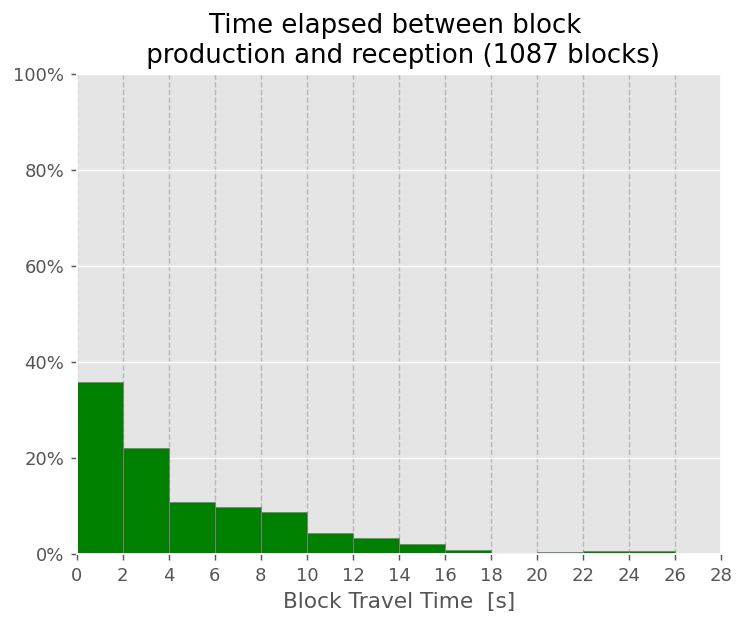

In [3]:
display(EXP_drop)
EXP = EXP_drop.value

# Generate the dataframe
df = create_df(EXP, 'block')
# df = df.get_param(df,'generic_params','block_period')

# Process the data  
bins = range(0, 30, 2)
# XX = df.groupby('HASH')['TELAPSED'].agg('max')
XX = df['TELAPSED']

# Create plot
ax = plt.axes()
hist, bins = np.histogram(XX, bins=bins)
ax.bar(bins[:-1]+(bins[1]-bins[0])/2, hist.astype(np.float32) / hist.sum(), width=(bins[1]-bins[0]), color='green', edgecolor='gray')
# ax = df['TELAPSED'].plot.hist(color='green', bins=bins, xticks=xticks)

# Edit plot
ax.grid(axis='x', linestyle='--', color='k', alpha=0.2) 
ax.set_title('Time elapsed between block \n production and reception (%s blocks)' % len(XX))

ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
ax.set_ylim(ymin=0, ymax = 1)
# ax.set_ylabel('Percentage of blocks received within')

ax.set_xticks(bins)
ax.set_xlim(xmin=bins[0], xmax = bins[-1])
ax.set_xlabel('Block Travel Time  [s]')

# Save plot
plt.savefig("plots/"+EXP+"/time_elapsed_recept.png", bbox_inches='tight', dpi=600)
plt.show()

## Time elapsed between consecutive blocks

Dropdown(description='Exp:', options=('test1',), value='test1')

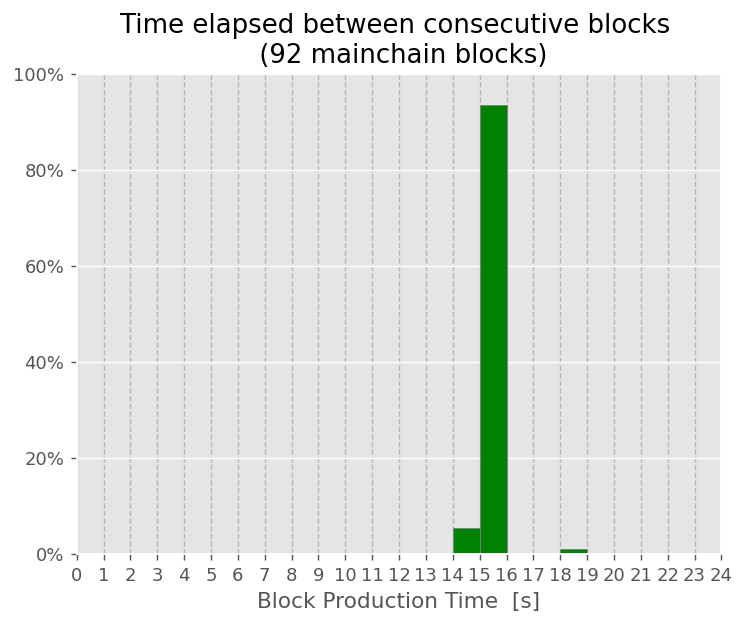

In [11]:
display(EXP_drop)
EXP = EXP_drop.value

# Generate the dataframe
df = create_df(EXP, 'block')

# Process the dataframe  
# df = df.get_param(df,'generic_params','block_period')
bins = range(0, 25, 1)

df = df.drop_duplicates('HASH')
df = trim_chain(df, 8).sort_values('TIMESTAMP')
df['TPROD'] = df.groupby(['EXP', 'REP'])['TIMESTAMP'].diff(1)

# Create plot
ax = plt.axes()
hist, bins = np.histogram(df['TPROD'], bins=bins)
ax.bar(bins[:-1]+(bins[1]-bins[0])/2, hist.astype(np.float32) / hist.sum(), width=(bins[1]-bins[0]), color='green', edgecolor='gray')
# ax = df['TPROD'].plot.hist(color='green', bins=bins, xticks=xticks)

# Edit plot
ax.set_title('Time elapsed between consecutive blocks \n (%s mainchain blocks)' % len(df))
ax.grid(axis='x', linestyle='--', color='k', alpha=0.2) 

ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
ax.set_ylim(ymin=0, ymax = 1)
# ax.set_ylabel('Percentage of blocks produced within')

ax.set_xticks(bins)
ax.set_xlim(xmin=bins[0], xmax = bins[-1])
ax.set_xlabel('Block Production Time  [s]')

# Save plot
plt.savefig("plots/"+EXP+"/time_elapsed_prod.png", dpi=600)
plt.show()

## Check how many blocks were produced

In [ ]:
# df = load_df('block')

# # Process the dataframe  
# df = df.get_param(df,'generic','block_period')
# df = df.drop_duplicates('HASH')
# YY = 'BLOCK'

# # df['main_leaf'] = df.groupby(['EXP', 'CFG', 'REP'], as_index=False)['TDIFF'].transform('idxmax').reset_index()

# dg = df.groupby(['EXP', 'CFG', 'REP'], as_index=False)

# for name, group in dg:
    
#     group = group.reset_index()
    
#     main_leaf = group[group['TDIFF'] == group['TDIFF'].max()]['HASH'].iloc[0]
    
#     # Iterate from main_leaf to genesis -> mainchain
#     df_mainchain = get_mainchain_df(group, main_leaf)          
# #     print(name, len(df_mainchain))


# get_mainchain_df(df, main_leaf)
# df.groupby(['EXP', 'CFG', 'REP'], as_index=False).apply(lambda x: get_mainchain_df(x, x['TDIFF']))

# display(df.groupby(['EXP', 'CFG', 'REP'], as_index=False).agg({YY:'max'}))
# display(main_df.groupby(['EXP', 'CFG', 'REP'], as_index=False).agg({YY:'max'}))




## Local memory occupied by chaindata

In [18]:
# display(EXP_multiple)
# EXP = EXP_multiple.value
display(EXP_drop)
EXP = EXP_drop.value
# print('Experiment datasets: '+','.join(EXP))

# Generate the dataframe
df = create_df(EXP, 'extra', exclude_patterns = ['greedy'])
df = get_param_df(df, 'generic_params', 'num_robots', alias = 'Robots')
df = df.query('Robots <= 25')

df['TEMP'] = df['TIME']/10
df['TIME_S'] = df['TEMP'].round().astype(int) * 10

# df = df.query('REP == "001"')
# display(df)
# Process the dataframe  
# df = df.groupby(['Robots']).apply(lambda x: LinearRegression(x, 'TIME', 'MB'))

# display(df[['Robots','MB']])
# Create plot


ax = plt.axes()
# display(df)
# df = df[['Robots','TIME_M','MB']]
# display(df.groupby(['Robots', 'TIME_M'], as_index=False).mean().set_index('TIME_M')['MB'])

df.groupby(['Robots', 'TIME_S'], as_index=False).mean().set_index('TIME_S')[['Robots','MB']].groupby('Robots')['MB'].plot(ax=ax)

# df.groupby('Robots').boxplot(column='MB', by='TIME_MR', figsize=double)
# sns.boxplot(x=df['TIME_MR'], y=df['MB'], hue=df['Robots'], showfliers = False)

# display(df)
# s = df.pivot('TIME_M', 'ID', 'MB').mean(axis=1).resample('0.15S').mean()

# display(df)
# df['MB_mov_avg'] = df.set_index(['TIME_M']).groupby('REP')['MB'].transform(lambda x: x.rolling(10, 1).mean())
# df['MB_mov_avg'] = df.set_index(['TIME_M']).groupby('REP').rolling(10)['MB'].mean().reset_index(drop=True)
# display(df)
# s.plot(ax = ax, figsize = double)
# display(df)
# df.set_index(['TIME']).groupby(['EXP', 'REP', 'ID'])['MB'].plot(ax = ax, color='gray', label='_nolegend_', linewidth=0.2, alpha = 0.1, zorder=0)

# Edit plot
# xmax = math.ceil(df['TIME'].max()/60)
# xticks = range(0,xmax,1)
# ax.set_xlim(xmin=0,xmax = xmax)
# ax.set_xticks(xticks) 
ax.set_xlabel('Runtime [minutes]')
ax.set_ylabel('Local storage costs [MB]')
ax.legend(loc='best', bbox_to_anchor=(1, 0.5), title = 'Number of\nrobots')
plt.gcf().tight_layout()

# Save plot
# plt.savefig("plots/experiment_"+EXP+"/local_memory.png", bbox_inches='tight', dpi=600)
# plt.savefig("plots/multi/local_memory.png", bbox_inches='tight', dpi=600)
plt.show()

Dropdown(description='Exp:', options=('test',), value='test')

FileNotFoundError: [Errno 2] No such file or directory: '/home/eksander/geth-pi-pucks/results/data/test/cfg/001/config.py'

In [ ]:
display(EXP_drop)
EXP = EXP_drop.value

# Generate the dataframe
df = create_df2(EXP, 'extra')
df = get_param_df2(df, 'generic_params', 'num_robots', alias = 'Robots')
df['TIME_M'] = df['TIME']/60
df = df.query('Robots <= 25')

# Plot options
XX = 'Robots'
YY = 'MB'
yl = 'Local storage costs [MB]'
fs = hlwidth

# Process the data
df = df.groupby(['EXP','CFG', 'REP']).apply(lambda x: LinearRegression0(x, 'TIME_M', 'MB'))
print(df.query('COEFS < 0.4'))
# df = df.groupby(['Robots', 'REP'], as_index=False).agg({YY:'max'})

# Create plot
# ax = plt.axes()
fig,ax = plt.subplots(1,1,figsize=fs) 

bp = df.boxplot(column='COEFS', by = XX, figsize=fs, ax=ax)
# bp = df.boxplot(column=[YY], by = XX, figsize=flhh, ax=ax)

# Edit plot 
plt.suptitle('')
ax.xaxis.set_minor_locator(ticker.NullLocator())
ax.xaxis.grid(False)
ax.yaxis.grid(True, linestyle = '--')
ax.set_xlabel("Number of %s" % ax.get_xlabel())
ax.set_ylabel(yl)
ax.set_title('')   

# Save plot
plt.gcf().tight_layout()
plt.savefig("plots/experiment_"+EXP+"/storage_bp_%s_%s.png" % (XX,YY), bbox_inches='tight', dpi=600)
plt.show()

In [ ]:
display(EXP_drop)
EXP = EXP_drop.value

# Generate the dataframe
df = create_df2(EXP, 'loop_function')
df = get_param_df2(df, 'generic_params', 'num_robots', alias = 'Robots')
df = df.query('Robots <= 25')

# Plot options
XX = 'Robots'
YY = 'VALUE'
yl = 'Reward'
fs = hlwidth

# Process the data
# df = df.groupby(['EXP', 'REP']).apply(lambda x: LinearRegression0(x, 'TIME_M', 'MB'))
df = df.groupby(['Robots', 'REP'], as_index=False).agg({YY:'max'})

# Create plot
fig,ax = plt.subplots(1,1,figsize=fs) 
# bp = df.boxplot(column='COEFS', by = XX, ax=ax)
# bp = df.boxplot(column=[YY], by = XX, ax=ax)
bp = sns.violinplot(df[XX], df[YY])
# Edit plot 
plt.suptitle('')
ax.xaxis.set_minor_locator(ticker.NullLocator())
ax.xaxis.grid(False)
ax.yaxis.grid(True, linestyle = '--')
ax.set_xlabel("Number of %s" % ax.get_xlabel())
ax.set_ylabel(yl)
ax.set_title('')   

# Save plot
plt.gcf().tight_layout()
plt.savefig("plots/experiment_"+EXP+"/performance_bp_%s_%s.png" % (XX,YY), bbox_inches='tight', dpi=600)
plt.show()

## Smart Contract Clusters

GridspecLayout(children=(Dropdown(description='Exp:', layout=Layout(grid_area='widget001'), options=('test', '…

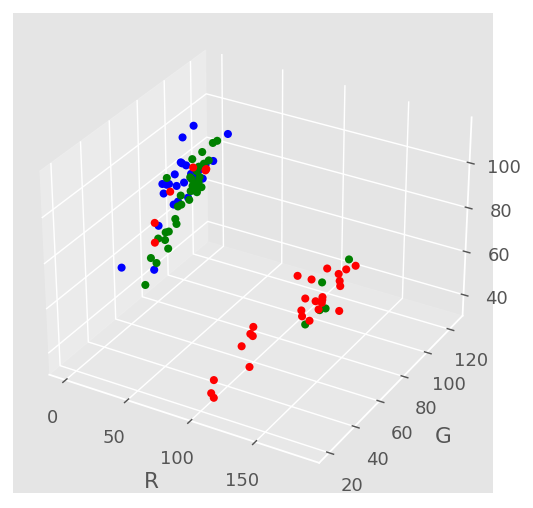

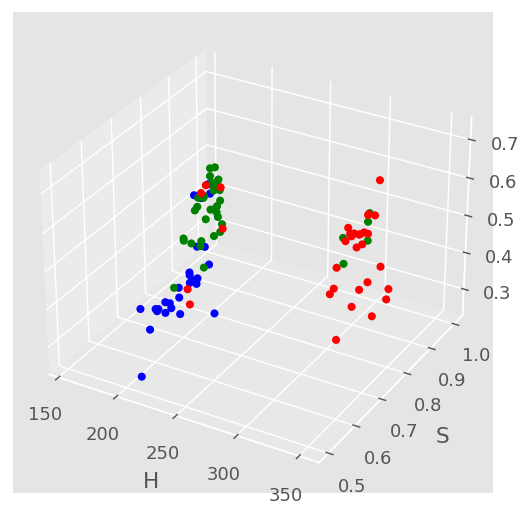

In [143]:
from numpy import array
df = load_df('color')
color_groups = df.groupby('NAME')

# for name, group in groups:
#     # plt.hist(group['B'], bins=20, color='red') 
#     # plt.hist(group['G'], bins=20, color='blue') 
#     # plt.hist(group['R'], bins=20, color='green') 
#     group['R'].plot.kde(color='red')
#     group['B'].plot.kde(color='blue')
#     group['G'].plot.kde(color='green')
#     plt.title(f"PDF Plot for Group {name}")
#     plt.xlabel('Value')
#     plt.ylabel('Probability Density')
#     plt.show()

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for name, group in color_groups:
    ax.scatter(group['R'], group['G'], group['B'], color=name, alpha=1.0, edgecolors='none')
ax.set_xlabel('R')
ax.set_ylabel('G')
ax.set_zlabel('B')

plt.show()

df['H'] = df.apply(lambda row: bgr_to_hsv(row['B'], row['G'], row['R'])[0], axis=1)
df['S'] = df.apply(lambda row: bgr_to_hsv(row['B'], row['G'], row['R'])[1], axis=1)
df['V'] = df.apply(lambda row: bgr_to_hsv(row['B'], row['G'], row['R'])[2], axis=1)

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for name, group in color_groups:
    ax.scatter(group['H'], group['S'], group['V'], color=name, alpha=1.0, edgecolors='none')
ax.set_xlabel('H')
ax.set_ylabel('S')
ax.set_zlabel('V')

plt.show()

# df['PTS'] = df.apply(lambda row: eval(row['SEEN_COLORS']), axis=1)
# colors = ['red','green','blue']
# dfpts = df.groupby(['ID']).agg('last')
# dfpts = dfpts.explode('PTS').query('PTS != 0')
# dfpts['PTS'] = dfpts.apply(lambda row: list(row['PTS'])[0], axis=1)

# for line in dfpts:
#     for point in line:
#         print(point)

# # Plot options
# XX = 'Robots'
# YY = 'MB'
# yl = 'Local storage costs [MB]'
# fs = hlwidth

# # Process the data
# df = df.groupby(['EXP','CFG', 'REP']).apply(lambda x: LinearRegression0(x, 'TIME_M', 'MB'))
# print(df.query('COEFS < 0.4'))

## Value Collected Over Distance Traveled 

In [ ]:
display(EXP_drop)
EXP = EXP_drop.value

# Generate the dataframe
df = create_df(EXP, 'loop_function')

# Axis data options
X_axis = 'TIME'

# Process the dataframe
df = df.groupby(['EXP']).apply(lambda x: LinearRegression0(x, X_axis, 'VALUE'))
# df = df[df['CONTROLLER'] == 'blockchain3']

# Create plot
ax = plt.axes()
df.set_index(X_axis).groupby(['EXP'])['LREG'].plot(ax=ax)
df.set_index(X_axis).groupby(['EXP','REP'])['VALUE'].plot(ax=ax, label='_nolegend_', color='gray', linestyle = '-', linewidth=0.2, alpha=0.3, zorder=0)

# Edit plot
ax.set_xlim(xmin=0,xmax = df[X_axis].max())
ax.set_ylabel('Reward')
if X_axis == 'DIST':
    ax.set_xlabel('Distance Traveled [m]')
else:
    ax.set_xlabel('Time [s]')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title = 'Experiment')

## Efficiency (boxplot)

In [ ]:
display(EXP_drop)
EXP = EXP_drop.value

# Generate the dataframe
df = create_df(EXP, 'loop_function')
df = get_param_df(df, 'generic', 'num_robots', alias = 'Robots')
df.loc[df['CONTROLLER'] == 'greedy', 'Recruits'] = 0

# Plot options
YY = 'SCOUT_DIST'
XX = 'CONTROLLER'
BP = 'Robots'
yl = 'Scouting efficiency'
fs = 0.66*hlwidth
# df = df.query('Recruits in [0,1]')
# df = df.query('Robots==25')

# Process the data
df = df.groupby(['EXP', 'REP']).apply(lambda x: LinearRegression0(x, YY, 'VALUE'))

# Create plot
bp = df.groupby(BP).boxplot(column='COEFS', by = XX, sharex=True, figsize=fs)

# Edit plot 
plt.suptitle('')
for axi in bp:axi.xaxis.set_minor_locator(ticker.NullLocator())
for axi in bp: axi.xaxis.grid(False)
for axi in bp: axi.yaxis.grid(True, linestyle = '--')
for axi in bp: axi.set_xlabel("Number of foragers")
# for axi in bp: axi.set_ylabel(yl)
for axi in bp: axi.set_title('')   

# bp[0].set_title('No Blockchain (Individualist)')
# bp[1].set_title('Blockchain (Individualist)')
plt.gcf().tight_layout()

# plt.savefig("plots/experiment_"+EXP+"/efficiency_bp_%s_%s.png" % (XX,YY), bbox_inches='tight', dpi=600)
plt.show()


## Total Value Collected (boxplot)

In [ ]:
# Generate the dataframe
df = load_df('loop_function')
df = get_param_df(df, 'generic', 'num_robots', alias = 'Robots')

# Plot options
YY = 'SCOUT_DIST'
XX = 'CONTROLLER'
BP = 'Robots'
yl = 'Scouting efficiency'
fs = 0.66*hlwidth

# Process the data
df = df.groupby(['EXP', 'REP']).apply(lambda x: LinearRegression0(x, YY, 'VALUE'))

# Create plot
bp = df.groupby(BP).boxplot(column='COEFS', by = XX, sharex=True, figsize=fs)

# Edit plot 
plt.suptitle('')
for axi in bp:axi.xaxis.set_minor_locator(ticker.NullLocator())
for axi in bp: axi.xaxis.grid(False)
for axi in bp: axi.yaxis.grid(True, linestyle = '--')
for axi in bp: axi.set_xlabel("Number of foragers")
# for axi in bp: axi.set_ylabel(yl)
for axi in bp: axi.set_title('')   

# bp[0].set_title('No Blockchain (Individualist)')
# bp[1].set_title('Blockchain (Individualist)')
plt.gcf().tight_layout()

# plt.savefig("plots/experiment_"+EXP+"/efficiency_bp_%s_%s.png" % (XX,YY), bbox_inches='tight', dpi=600)
plt.show()

In [ ]:
display(EXP_multiple)
EXP = EXP_multiple.value

# Generate the dataframe
df = create_df2(EXP, 'loop_function')
df = get_param_df2(df, 'generic_params', 'num_robots', alias = 'Robots')
df = get_param_df2(df, 'generic_params', 'max_recruits', alias = 'Recruits')
df.loc[df['CONTROLLER'] == 'greedy', 'Recruits'] = 0

# Plot options
YY = 'VALUE'
XX = 'Recruits'
BP = 'EXP'
yl = 'Reward'
titles = ['Scattered', 'Concentrated', 'Hotspot']
fs = fl22

# Process the data
df = df.groupby(['EXP', 'CFG','Recruits', 'REP'], as_index=False).agg({YY:'max'})

# Create plot
bp = df.groupby(BP).boxplot(column=[YY], by = XX, sharey=True, figsize=fs, layout=[1,3])

# Edit plot 
plt.suptitle('')
for axi in bp:axi.xaxis.set_minor_locator(ticker.NullLocator())
for axi in bp: axi.xaxis.grid(False)
for axi in bp: axi.yaxis.grid(True, linestyle = '--')
for axi in bp: axi.set_xlabel("")
for axi in bp: 
    labels = axi.get_xticklabels()
    labels[0] = 'NA'
    axi.set_xticklabels("")
    
bp[0].set_ylabel(yl)
i=0
for axi in bp: 
    axi.set_title(titles[i]) 
    i = i+1
plt.gcf().tight_layout()

plt.savefig("plots/multi/value.png", bbox_inches='tight', dpi=600)
plt.show()
#######################################################################################################

# Generate the dataframe
df = create_df2(EXP, 'loop_function')
df = get_param_df2(df, 'generic_params', 'num_robots', alias = 'Robots')
df = get_param_df2(df, 'generic_params', 'max_recruits', alias = 'Recruits')
df.loc[df['CONTROLLER'] == 'greedy', 'Recruits'] = 0
# df = df[pd.to_numeric(df['REP']) >= 10]
# Plot options
YY = 'SCOUT_DIST'
XX = 'Recruits'
BP = 'EXP'
yl = 'Scouting efficiency'
fs = fl22

# Process the data
df = df.groupby(['EXP', 'CFG', 'REP']).apply(lambda x: LinearRegression0(x, YY, 'VALUE'))

# Create plot
bp = df.groupby(BP).boxplot(column='COEFS', by = XX, sharey=True, figsize=fs, layout=[1,3])

# Edit plot 
plt.suptitle('')
for axi in bp:axi.xaxis.set_minor_locator(ticker.NullLocator())
for axi in bp: axi.xaxis.grid(False)
for axi in bp: axi.yaxis.grid(True, linestyle = '--')
for axi in bp: axi.set_xlabel("Number of foragers")
for axi in bp: 
    labels = axi.get_xticklabels()
    labels[0] = 'NA'
    axi.set_xticklabels(labels)
for axi in bp: axi.set_title('')  
    
bp[0].set_ylabel(yl)
plt.gcf().tight_layout()

plt.savefig("plots/multi/eff.png", bbox_inches='tight', dpi=600)
plt.show()


## Distance Travelled Ratio (boxplot)

In [ ]:
display(EXP_drop)
EXP = EXP_drop.value

# Generate the dataframe
df = create_df(EXP, 'loop_function')
df = get_param_df(df, 'generic', 'num_robots', alias = 'Robots')
df = get_param_df(df, 'generic', 'max_recruits', alias = 'Recruits')
df.loc[df['CONTROLLER'] == 'greedy', 'Recruits'] = 0

# Plot options
XX = 'CONTROLLER'
BP = 'Robots'
fs = hlwidth
# df = df.query('Robots==20')

# Process the dataframe  
df['%DIST_RECRUIT'] = df['RECRUIT_DIST']/df['SCOUT_DIST']
df = df.groupby(['Robots','CONTROLLER', 'REP'], as_index=False).agg({'%DIST_RECRUIT':'mean'})

# Create plot
bp = df.groupby(BP).boxplot(column=['%DIST_RECRUIT'], by=XX, sharey=True, layout=(2,2))

# Edit plot 
plt.suptitle('')
for ax in bp: ax.set_xlabel("Number of %s" % XX)
for ax in bp: ax.set_ylabel("Ratio (Re/Sc)")
for ax in bp: ax.set_title('') 
# plt.gcf().tight_layout()

plt.savefig("plots/experiment_"+EXP+"/ratio_bp_%s.png" % XX, bbox_inches='tight', dpi=600)
plt.show()

## Reward V Time (plot)

In [ ]:
# Generate the dataframe
df = load_df('loop_function')
df = get_param_df(df, 'generic', 'num_robots', alias = 'Robots')
df = get_param_df(df, 'experiment', 'MAXWORKERS', alias = 'limit')
df = get_param_df(df, 'experiment', 'EPSILON', alias = 'epsilon')
df = get_param_df(df, 'patches', 'radius', alias = 'Patch Radius')

# Plot options
XX = 'TIME'
YY = 'VALUE'
BP = 'Robots'
yl = 'Reward'
xl = 'Time'
fs = xm(2)*flwidth

# Process the data 
# df["CONTROLLER"] = pd.to_numeric(df["CONTROLLER"]
df = df.set_index(XX).groupby(['REP','Patch Radius'])

ax = plt.axes()

# Create plot
df[YY].plot(ax=ax)

# Edit plot 
plt.suptitle('')
ax.xaxis.set_minor_locator(ticker.NullLocator())
ax.xaxis.grid(False)
ax.yaxis.grid(True, linestyle = '--')
ax.set_xlabel(xl)
ax.set_ylabel(yl)
ax.set_title('') 
# ax.set_ylim(ymin=0, ymax = df[YY].max()*1.1)
    
plt.gcf().tight_layout()

# plt.savefig("plots/experiment_"+EXP+"/value_bp_%s_%s.png" % (XX,YY), bbox_inches='tight', dpi=600)
plt.show()

## Collected V Time (plot)

In [ ]:
# Generate the dataframe
df = load_df('loop_function')
df = get_param_df(df, 'generic', 'num_robots', alias = 'Robots')
df = get_param_df(df, 'experiment', 'MAXWORKERS', alias = 'limit')
df = get_param_df(df, 'experiment', 'EPSILON', alias = 'epsilon')
df = get_param_df(df, 'patches', 'radius', alias = 'Patch Radius')

# Plot options
XX = 'TIME'
YY = ['red', 'green', 'blue', 'yellow']
BP = 'Robots'
yl = 'Number Collected'
xl = 'Time'
fs = xm(2)*flwidth

# Process the data 
# df["CONTROLLER"] = pd.to_numeric(df["CONTROLLER"]
# df = df.set_index(XX).groupby(['REP','Patch Radius'])

ax = plt.axes()

# Create plot
df.set_index(XX)[YY].plot.area(ax=ax, color = YY, linestyle = '-')

# Edit plot 
plt.suptitle('')
ax.xaxis.set_minor_locator(ticker.NullLocator())
ax.xaxis.grid(False)
ax.yaxis.grid(True, linestyle = '--')
ax.set_xlabel(xl)
ax.set_ylabel(yl)
ax.set_title('') 
# ax.set_ylim(ymin=0, ymax = 100)
    
plt.gcf().tight_layout()

# plt.savefig("plots/experiment_"+EXP+"/value_bp_%s_%s.png" % (XX,YY), bbox_inches='tight', dpi=600)
plt.show()

## Reward (boxplot)

In [16]:
# Generate the dataframe
df = load_df('loop_function')
df = get_param_df(df, 'generic', 'num_robots', alias = 'Robots')
df = get_param_df(df, 'experiment', 'MAXWORKERS', alias = 'limit')
df = get_param_df(df, 'experiment', 'EPSILON', alias = 'epsilon')

# Plot options
XX = 'CFG'
YY = 'VALUE'
BP = 'Robots'
yl = 'Reward'
xl = 'Config'
fs = xm(2)*flwidth

# Process the data 
# df["CONTROLLER"] = pd.to_numeric(df["CONTROLLER"]

df = df.groupby(['Robots', 'CFG', 'REP'], as_index=False).agg({YY:'max'})

# Create plot
bp = df.groupby(BP).boxplot(column=[YY], by = XX, sharex=True, figsize=fs, layout=(1,1))

# Edit plot 
plt.suptitle('')
for axi in bp:axi.xaxis.set_minor_locator(ticker.NullLocator())
for axi in bp: axi.xaxis.grid(False)
for axi in bp: axi.yaxis.grid(True, linestyle = '--')
for axi in bp: axi.set_xlabel(xl)
for axi in bp: axi.set_ylabel(yl)
for axi in bp: axi.set_title('') 
for axi in bp: axi.set_ylim(ymin=0, ymax = df[YY].max()*1.1)
    
plt.gcf().tight_layout()

# plt.savefig("plots/experiment_"+EXP+"/value_bp_%s_%s.png" % (XX,YY), bbox_inches='tight', dpi=600)
plt.show()

GridspecLayout(children=(Dropdown(description='Exp:', layout=Layout(grid_area='widget001'), options=('test',),…

Dataset /home/eksander/geth-pi-pucks/results/data/experiment_test not found
Loaded dataframe: test // datafile: loop_function


AttributeError: 'NoneType' object has no attribute 'groupby'

Dataset /home/eksander/geth-pi-pucks/results/data/experiment_test not found
Loaded dataframe: test // datafile: loop_function


## Reward V Patch Size (boxplot)

In [ ]:
# Generate the dataframe
df = load_df('loop_function')
df = get_param_df(df, 'generic', 'num_robots', alias = 'Robots')
df = get_param_df(df, 'patches', 'radius', alias = 'Patch Radius')

# Plot options
XX = 'Patch Radius'
YY = 'VALUE'
BP = 'CFG'
yl = 'Reward'
xl = 'Patch Radius'
fs = 3*default

# Process the data 
# df["CONTROLLER"] = pd.to_numeric(df["CONTROLLER"])
df = df.groupby([XX, 'CFG', 'REP'], as_index=False).agg({YY:'max'})

# Create plot
bp = df.groupby(BP).boxplot(column=[YY], by = XX, sharex=True, figsize=fs, layout=(5,5))

# Edit plot 
plt.suptitle('')
for axi in bp:axi.xaxis.set_minor_locator(ticker.NullLocator())
for axi in bp: axi.xaxis.grid(False)
for axi in bp: axi.yaxis.grid(True, linestyle = '--')
for axi in bp: axi.set_xlabel(xl)
for axi in bp: axi.set_ylabel(yl)
# for axi in bp: axi.set_title('') 
for axi in bp: axi.set_ylim(ymin=0, ymax = df[YY].max()*1.1)
    
plt.gcf().tight_layout()

# plt.savefig("plots/experiment_"+EXP+"/value_bp_%s_%s.png" % (XX,YY), bbox_inches='tight', dpi=600)
plt.show()

## Efficiency V Patch Size (boxplot)

In [ ]:
# Generate the dataframe
df = load_df('loop_function')
df = get_param_df(df, 'generic', 'num_robots', alias = 'Robots')
df = get_param_df(df, 'patches', 'radius', alias = 'Patch Radius')

# Plot options
XX = 'Patch Radius'
YY = 'DIST'
BP = 'CFG'
yl = 'Efficiency'
xl = 'Patch Radius'
fs = 3*default

# Process the data
df = df.groupby([XX, 'CFG', 'REP']).apply(lambda x: LinearRegression0(x, YY, 'VALUE'))

# Create plot
bp = df.groupby(BP).boxplot(column='COEFS', by = XX, sharex=True, figsize=fs, layout=(3,3))

# Edit plot 
plt.suptitle('')
for axi in bp:axi.xaxis.set_minor_locator(ticker.NullLocator())
for axi in bp: axi.xaxis.grid(False)
for axi in bp: axi.yaxis.grid(True, linestyle = '--')
for axi in bp: axi.set_ylabel(yl)
for axi in bp: axi.set_xlabel(xl)
# for axi in bp: axi.set_title('')   
for axi in bp: axi.set_ylim(ymin=0, ymax = df['COEFS'].max()*1.1)
    
plt.gcf().tight_layout()
# plt.savefig("plots/experiment_"+EXP+"/efficiency_bp_%s_%s.png" % (XX,YY), bbox_inches='tight', dpi=600)
plt.show()

## Smart Contract (plot)

In [ ]:
# Generate the dataframe
df = load_df('sc')
df = get_param_df(df, 'generic', 'num_robots', alias = 'Robots')
display(df)

# Plot options
XX = 'BLOCK'
YY = 'WCOUNT'
yl = 'Number of Workers'
xl = 'Block'
fs = double

# Process the data
df["XY"] = df["X"].astype(str)
+ df["Y"].astype(str)
df = df.drop_duplicates(['HASH','XY']).sort_values('BLOCK').reset_index()

main_leaf = df.iloc[-1]['HASH']
main_df = get_mainchain_df(df, main_leaf).reset_index()
df = df[df['HASH'].isin(main_df['HASH'])]

dfp = df[[YY, 'BLOCK','QLTY']].pivot(columns='QLTY', values=YY).fillna(0).astype(int)
dfp['BLOCK'] = df['BLOCK']
dfp = dfp.set_index('BLOCK')

# Create plot
ax = plt.axes()
dfp.groupby('BLOCK').agg('sum').plot.area(color=dfp.columns.values,linestyle='None', legend='None', ax=ax)

# Edit plot 
plt.suptitle('')
ax.xaxis.grid(False)
ax.yaxis.grid(True, linestyle = '--')

ax.set_xlabel(xl)
ax.set_ylabel(yl)
ax.set_title('')   
ax.get_legend().remove()

# Save plot
plt.gcf().tight_layout()
# plt.savefig("plots/experiment_"+EXP+"/storage_bp_%s_%s.png" % (XX,YY), bbox_inches='tight', dpi=600)
plt.show()

## Firm (plot)

In [ ]:
# Generate the dataframe
df = load_df('firm')
df = get_param_df(df, 'generic', 'num_robots', alias = 'Robots')
df = get_param_df(df, 'patches', 'utility', alias = 'Reward')

df['C'] = df.apply(lambda row: eval(row['C'].replace(',', ', ')), axis=1)
df['MC'] = df.apply(lambda row: eval(row['MC'].replace(',', ', ')), axis=1)
df['Reward'] = df.apply(lambda row: eval(row['Reward'])['blue'], axis=1)

# Plot options
XX = 'CFG'
YY = 'WCOUNT'
yl = 'Price/Cost'
xl = 'Quantity'
fs = default

display(df)
df = df.query('TIME>800')

# Create plot
fig, ax = plt.figure(figsize=fs), plt.axes()

plt.axhline(y = df['Reward'].mean(), color = 'k', linestyle = '--', label="Market Price")
label_mc, label_atc  = "Marginal Cost", "Average Total Cost"

## Average Total Cost
dfa, i = pd.DataFrame(), 0
for g,d in df.explode('C').groupby('TIME'):
    d.reset_index(inplace=True)
    d.index += 1
    ((d['C']+d['FC'])/d.index).plot(ax=ax, linestyle = '', linewidth = '0.2', marker='*', markersize='5', color = 'r', label=label_atc)
    label_atc = "_nolegend_"
    i+=1
    dfa[str(i)] =(d['C']+d['FC'])/d.index

## Average Total Cost Mean
dfa_mean = dfa.mean(axis=1)
dfa_mean.plot(ax=ax, linestyle = '--', linewidth = '2',marker='', markersize='2.5', color = 'r', label="ATC (mean)")

dfa, i = pd.DataFrame(), 0

## Marginal Cost
for g,d in df.explode('MC').groupby('TIME'):
    d.reset_index(inplace=True)
    d.index +=2
    (d['MC']).plot(ax=ax, linestyle = '', linewidth = '0.5',marker='*', markersize='5', color = 'k', label=label_mc)
    label_mc = "_nolegend_"
    i+=1
    dfa[str(i)] =d['MC']
    
## Marginal Cost Mean
dfa_mean = dfa.mean(axis=1)  
dfa_mean.plot(ax=ax, linestyle = '--', linewidth = '2',marker='', markersize='2.5', color = 'k', label="MC (mean)")

    
# for g,d in df.explode('C').groupby('TIME'):
#     d.reset_index(inplace=True)
#     d.index += 1
#     (d['C']+d['FC']).plot(ax=ax, linestyle = '-', linewidth = '0.5', marker='*', markersize='2.5', color = 'g')
    

# Edit plot 
plt.suptitle('')
ax.xaxis.set_minor_locator(ticker.NullLocator())
# ax.xaxis.set_ticks(d.index-1)
ax.xaxis.grid(False)
ax.yaxis.grid(True, linestyle = '--')
ax.set_xlabel(xl)
ax.set_ylabel(yl)
ax.set_title('') 
ax.set_ylim(ymin=0, ymax = 30)
# ax.set_xlim(xmin=0, xmax = 20)
ax.legend()

plt.gcf().tight_layout()

# plt.savefig("plots/experiment_"+EXP+"/value_bp_%s_%s.png" % (XX,YY), bbox_inches='tight', dpi=600)
plt.show()

In [ ]:
# Generate the dataframe
df = load_df('firm')
df = get_param_df(df, 'generic', 'num_robots', alias = 'Robots')
df = get_param_df(df, 'patches', 'utility', alias = 'Reward')

df['C'] = df.apply(lambda row: eval(row['C'].replace(',', ', ')), axis=1)
df['MC'] = df.apply(lambda row: eval(row['MC'].replace(',', ', ')), axis=1)
df['Reward'] = df.apply(lambda row: eval(row['Reward'])['blue'], axis=1)

# Plot options
XX = 'CFG'
YY = 'WCOUNT'
yl = 'Price/Cost'
xl = 'Quantity'
fs = default

df = df.query('TIME<800')
# display(df)

# Create plot
fig, ax = plt.figure(figsize=fs), plt.axes()

plt.axhline(y = df['Reward'].mean(), color = 'k', linestyle = '--', label="Market Price")
label_mc, label_atc  = "Marginal Cost", "Average Total Cost"

## Actual Drops
df.set_index('Q')['ATC'].plot(ax=ax, linestyle = '', linewidth = '0.5',marker='*', markersize='5', color = 'b', label="Actual")

## Average Total Cost
dfa, i = pd.DataFrame(), 0
for g,d in df.explode('C').groupby('TIME'):
    d.reset_index(inplace=True)
    d.index += 1
    ((d['C']+d['FC'])/d.index).plot(ax=ax, linestyle = '', linewidth = '0.2', marker='.', markersize='2', color = 'r', label=label_atc)
    label_atc = "_nolegend_"
    i+=1
    dfa[str(i)] =(d['C']+d['FC'])/d.index

## Average Total Cost Mean
dfa_mean = dfa.mean(axis=1)
dfa_mean.plot(ax=ax, linestyle = '--', linewidth = '2',marker='', markersize='2.5', color = 'r', label="ATC (mean)")

dfa, i = pd.DataFrame(), 0

## Marginal Cost
for g,d in df.explode('MC').groupby('TIME'):
    d.reset_index(inplace=True)
    d.index +=2
    (d['MC']).plot(ax=ax, linestyle = '', linewidth = '0.5',marker='.', markersize='2', color = 'k', label=label_mc)
    label_mc = "_nolegend_"
    i+=1
    dfa[str(i)] =d['MC']
    
## Marginal Cost Mean
dfa_mean = dfa.mean(axis=1)  
dfa_mean.plot(ax=ax, linestyle = '--', linewidth = '2',marker='', markersize='2.5', color = 'k', label="MC (mean)")

    
# for g,d in df.explode('C').groupby('TIME'):
#     d.reset_index(inplace=True)
#     d.index += 1
#     (d['C']+d['FC']).plot(ax=ax, linestyle = '-', linewidth = '0.5', marker='*', markersize='2.5', color = 'g')
    

# Edit plot 
plt.suptitle('')
ax.xaxis.set_minor_locator(ticker.NullLocator())
# ax.xaxis.set_ticks(d.index-1)
ax.xaxis.grid(False)
ax.yaxis.grid(True, linestyle = '--')
ax.set_xlabel(xl)
ax.set_ylabel(yl)
ax.set_title('') 
ax.set_ylim(ymin=0, ymax = 30)
# ax.set_xlim(xmin=0, xmax = 20)
ax.legend()

plt.gcf().tight_layout()

# plt.savefig("plots/experiment_"+EXP+"/value_bp_%s_%s.png" % (XX,YY), bbox_inches='tight', dpi=600)
plt.show()

## SC (Balances)

In [ ]:
# Generate the dataframe
df = load_df('sc')
df = get_param_df(df, 'generic', 'num_robots', alias = 'Robots')
df = get_param_df(df, 'patches', 'utility', alias = 'Reward')

# Plot options
XX = 'TIME'
YY = 'BALANCE'
yl = 'Price/Cost'
xl = 'Time'
fs = double

# Corrections to dataframe
df['BALANCE'] = df['QTTY']
df = df.set_index(XX)
# df['Reward'] = df.apply(lambda row: eval(row['Reward'])['blue'], axis=1)
# display(df)


# Create plot
fig, ax = plt.figure(figsize=fs), plt.axes()

## Balance
df.groupby(['REP','ID'])[YY].plot(ax=ax, linestyle = '-', linewidth = '0.5', markersize='5')

# Edit plot 
plt.suptitle('')
ax.xaxis.set_minor_locator(ticker.NullLocator())
# ax.xaxis.set_ticks(d.index-1)
ax.xaxis.grid(False)
ax.yaxis.grid(True, linestyle = '--')
ax.set_xlabel(xl)
ax.set_ylabel(yl)
ax.set_title('') 
# ax.set_ylim(ymin=0, ymax = 30)
# ax.set_xlim(xmin=0, xmax = 20)
ax.legend()

plt.gcf().tight_layout()

# plt.savefig("plots/experiment_"+EXP+"/value_bp_%s_%s.png" % (XX,YY), bbox_inches='tight', dpi=600)
plt.show()

## Epoch (Unit Cost over Time)

In [ ]:
# Generate the dataframe
df = load_df('epoch')
df = get_param_df(df, 'generic', 'num_robots', alias = 'Robots')
df = get_param_df(df, 'patches', 'utility', alias = 'utility')
# display(df)

# Plot options
XX = 'start'
YY = 'ATC'
yl = 'Price / Cost'
xl = 'Time (Block number)'
fs = double
labels = ["Market Price", "Marginal Cost", "Average Total Cost", "Number of Workers"]

# Corrections to dataframe
df = df.drop_duplicates(subset=['number','start', 'Q', 'TC'])
if 'BSTART' in df and not df['BSTART'].isnull().values.any():
    df['start'] = df['BSTART']
df['utility'] = df.apply(lambda row: eval(row['utility'])['blue'], axis=1)
df['Q'] = df.apply(lambda row: eval(row['Q'].replace(',', ', ')), axis=1)
df['TC'] = df.apply(lambda row: eval(row['TC'].replace(',', ', ')), axis=1)
df['ATC'] = df.apply(lambda row: eval(row['ATC'].replace(',', ', ')), axis=1)
df['AATC'] = df.apply(lambda row: sum([a*b for a,b in zip(row['Q'],row['ATC'])])/sum(row['Q']), axis=1)
df['TQ'] = df.apply(lambda row: sum(row['Q']), axis=1)
df['WORKERS'] = df.apply(lambda row: len(row['Q']), axis=1)
df['MPRICE'] = df.apply(lambda row: row['price']*row['utility'], axis=1)
df = df.set_index(XX)            

# Create plot
fig, ax = plt.figure(figsize=fs), plt.axes()

## Market price 
plt.axhline(y = df['utility'].mean()*1000, color = 'k', linestyle = '--', label=labels[0])
df.groupby(['CFG','REP'])['MPRICE'].plot(ax=ax, linestyle = '--', color = 'k', label=labels[0])

## ATC 
df.explode(YY).groupby(XX)[YY].plot(ax=ax, linestyle = '', marker='.', markersize='2.5', color = 'r', label=labels[1])

## ATC 
YY = 'AATC'
df.groupby(['CFG','REP'])[YY].plot(ax=ax, linestyle = '-', linewidth = '0.5', marker='*', markersize='5', color = 'r', label=labels[1])

## Workers
ax2 = ax.twinx() 
df.groupby(['CFG','REP'])['WORKERS'].plot(ax=ax2, drawstyle="steps-post", linestyle = '-', marker='.', linewidth = '0.5', color = 'k', label=labels[3])

# display(df)
# Edit plot 
plt.suptitle('')
ax.xaxis.set_minor_locator(ticker.NullLocator())
# ax.xaxis.set_ticks(d.index-1)
ax.xaxis.grid(False)
ax.yaxis.grid(True, linestyle = '--')
ax.set_xlabel(xl)
ax.set_ylabel(yl)
ax.set_title('') 
# ax.set_ylim(ymin=0, ymax = 30)
# ax.set_xlim(xmin=0, xmax = 20)
# ax.legend()

plt.gcf().tight_layout()

# plt.savefig("plots/experiment_"+EXP+"/value_bp_%s_%s.png" % (XX,YY), bbox_inches='tight', dpi=600)
plt.show()

## Epoch (Total Profit)

In [ ]:
# Generate the dataframe
df = load_df('epoch')
df = get_param_df(df, 'generic', 'num_robots', alias = 'Robots')
df = get_param_df(df, 'patches', 'utility', alias = 'utility')

# Corrections to dataframe
df = df.drop_duplicates(subset=['number','start', 'Q', 'TC'])
if 'BSTART' in df and not df['BSTART'].isnull().values.any():
    df['start'] = df['BSTART']
df['utility'] = df.apply(lambda row: eval(row['utility'])['blue'], axis=1)
df['Q'] = df.apply(lambda row: eval(row['Q'].replace(',', ', ')), axis=1)
df['TC'] = df.apply(lambda row: eval(row['TC'].replace(',', ', ')), axis=1)
df['ATC'] = df.apply(lambda row: eval(row['ATC'].replace(',', ', ')), axis=1)
df['AATC'] = df.apply(lambda row: sum([a*b for a,b in zip(row['Q'],row['ATC'])])/sum(row['Q']), axis=1)
df['WORKERS'] = df.apply(lambda row: len(row['Q']), axis=1)
df['MPRICE'] = df.apply(lambda row: row['price']*row['utility'], axis=1)
df['DURATION'] = df['start'].diff()

df['TQ'] = df.apply(lambda row: sum(row['Q']), axis=1)
df['TQTIME'] = df.apply(lambda row: row['TQ']/row['DURATION']/2, axis=1)
df['TREVENUE'] = df.apply(lambda row: sum([q*row['price']*row['utility'] for q in row['Q']]), axis=1)
df['TCOST'] = df.apply(lambda row: sum(row['TC']), axis=1)
df['TPROFIT'] = df.apply(lambda row: (row['TREVENUE']-row['TCOST']), axis=1)
df['TPROFITPERROBOT'] = df.apply(lambda row: (row['TREVENUE']-row['TCOST'])/row['WORKERS'], axis=1)
df['TPROFITCUMSUM'] =  df.groupby('REP')['TPROFIT'].transform(pd.Series.cumsum)
df['TPROFITSCALED'] = df.apply(lambda row: (row['TREVENUE']-row['TCOST'])/100, axis=1)
df['TPROFITTIME'] = df.apply(lambda row: row['TPROFIT']/row['DURATION'], axis=1)

# Plot options
XX = 'start'
YY = 'TPROFIT'
yl = YY
xl = 'Time (Block number)'
fs = double
labels = ["Market Price", "Marginal Cost", "Average Total Cost", "Number of Workers"]

# Create plot
fig, ax = plt.figure(figsize=fs), plt.axes()

df.set_index(XX).groupby(['CFG','REP'])[YY].plot(ax=ax, linestyle = '-', marker='.', linewidth = '0.5', color = 'r', label=labels[1])

## Workers
ax2 = ax.twinx() 
df.set_index(XX).groupby(['CFG','REP'])['WORKERS'].plot(ax=ax2, linestyle = '-', marker='.', linewidth = '0.5', color = 'k', label=labels[3])

# display(df)
# Edit plot 
plt.suptitle('')
ax.xaxis.set_minor_locator(ticker.NullLocator())
# ax.xaxis.set_ticks(d.index-1)
ax.xaxis.grid(False)
ax.yaxis.grid(True, linestyle = '--')
ax.set_xlabel(xl)
ax.set_ylabel(yl)

ax.set_title('') 
# ax.set_ylim(ymin=0, ymax = 30)
# ax.set_xlim(xmin=0, xmax = 20)
# ax.legend()
plt.gcf().tight_layout()

# plt.savefig("plots/experiment_"+EXP+"/value_bp_%s_%s.png" % (XX,YY), bbox_inches='tight', dpi=600)
plt.show()

## Epoch (Profit Boxplot)

In [ ]:
# Generate the dataframe
df = load_df('epoch')
df = get_param_df(df, 'generic', 'num_robots', alias = 'Robots')
df = get_param_df(df, 'patches', 'utility', alias = 'utility')

# Corrections to dataframe
df = df.drop_duplicates(subset=['number','start', 'Q', 'TC'])
df['CFG'] = df['CFG'].astype('int')

if 'BSTART' in df and not df['BSTART'].isnull().values.any():
    df['start'] = df['BSTART']
df['utility'] = df.apply(lambda row: eval(row['utility'])['blue'], axis=1)
df['Q'] = df.apply(lambda row: eval(row['Q'].replace(',', ', ')), axis=1)
df['TC'] = df.apply(lambda row: eval(row['TC'].replace(',', ', ')), axis=1)
df['ATC'] = df.apply(lambda row: eval(row['ATC'].replace(',', ', ')), axis=1)
df['AATC'] = df.apply(lambda row: sum([a*b for a,b in zip(row['Q'],row['ATC'])])/sum(row['Q']), axis=1)
df['WORKERS'] = df.apply(lambda row: len(row['Q']), axis=1)
df['MPRICE'] = df.apply(lambda row: row['price']*row['utility'], axis=1)
df['DURATION'] = df['start'].diff()

df['TQ'] = df.apply(lambda row: sum(row['Q']), axis=1)
df['TQTIME'] = df.apply(lambda row: row['TQ']/row['DURATION']/2, axis=1)
df['TREVENUE'] = df.apply(lambda row: sum([q*row['price']*row['utility'] for q in row['Q']]), axis=1)
df['TCOST'] = df.apply(lambda row: sum(row['TC']), axis=1)
df['TPROFIT'] = df.apply(lambda row: (row['TREVENUE']-row['TCOST']), axis=1)
df['TPROFITPERROBOT'] = df.apply(lambda row: (row['TREVENUE']-row['TCOST'])/row['WORKERS'], axis=1)
df['TPROFITCUMSUM'] =  df.groupby(['CFG','REP'])['TPROFIT'].transform(pd.Series.cumsum)
df['TPROFITSCALED'] = df.apply(lambda row: (row['TREVENUE']-row['TCOST'])/100, axis=1)
df['TPROFITTIME'] = df.apply(lambda row: row['TPROFIT']/row['DURATION'], axis=1)

# Plot options
# display(df[['ATC', 'AATC']])
XX = 'start'
YY = 'TQ'
BP = 'REP'
yl = YY
xl = 'Time (Block number)'
fs = double
labels = ["Market Price", "Marginal Cost", "Average Total Cost", "Number of Workers"]

# Create plot
fig, ax = plt.figure(figsize=fs), plt.axes()


df = df.groupby(['CFG', 'REP'], as_index=False).agg({YY:'sum', 'TCOST':'sum'})
df['ATCOST'] = df['TCOST']/df[YY]
display(df)

# Create plot
bp = df.groupby(BP).boxplot(column=[YY], by = XX, sharex=True, figsize=fs, layout=(1,1))


# df.set_index(XX).groupby('REP')[YY].plot(ax=ax, linestyle = '-', marker='.', linewidth = '0.5', color = 'r', label=labels[1])

# ## Workers
# ax2 = ax.twinx() 
# df.set_index(XX).groupby('REP')['WORKERS'].plot(ax=ax2, linestyle = '-', marker='.', linewidth = '0.5', color = 'k', label=labels[3])

# display(df)
# Edit plot 
plt.suptitle('')
ax.xaxis.set_minor_locator(ticker.NullLocator())
# ax.xaxis.set_ticks(d.index-1)
ax.xaxis.grid(False)
ax.yaxis.grid(True, linestyle = '--')
ax.set_xlabel(xl)
ax.set_ylabel(yl)

ax.set_title('') 
# ax.set_ylim(ymin=0, ymax = 30)
# ax.set_xlim(xmin=0, xmax = 20)
# ax.legend()
plt.gcf().tight_layout()

# plt.savefig("plots/experiment_"+EXP+"/value_bp_%s_%s.png" % (XX,YY), bbox_inches='tight', dpi=600)
plt.show()

## Patches (Quantity)

In [ ]:
# Generate the dataframe
df = load_df('patches')
df = get_param_df(df, 'generic', 'num_robots', alias = 'Robots')
df = get_param_df(df, 'patches', 'utility', alias = 'utility')

# Plot options
XX = 'TIME'
YY = 'QTTY'
yl = 'Quantity at Patch'
xl = 'Time (s)'
fs = double
labels = ["Market Price", "Marginal Cost", "Average Total Cost", "Number of Workers"]

# df['QTTY'] = df.apply(lambda row: {x.split(':')[0]: x.split(':')[1] for x in row['JSON'].split(',')}['quantity'], axis=1)
df['QTTY'] = df.apply(lambda row: eval(row['JSON'])['quantity'], axis=1)

df = df.set_index(XX)  

# Create plot
fig, ax = plt.figure(figsize=fs), plt.axes()

# Quantity at patch
df['QTTY'].astype('int').plot(ax=ax, drawstyle="steps", linestyle = '-', color = 'r', label=labels[1])

# Edit plot 
plt.suptitle('')
ax.xaxis.set_minor_locator(ticker.NullLocator())
ax.xaxis.grid(False)
ax.yaxis.grid(True, linestyle = '--')
ax.set_xlabel(xl)
ax.set_ylabel(yl)
ax.set_title('') 
# ax.legend()
plt.gcf().tight_layout()

# plt.savefig("plots/experiment_"+EXP+"/value_bp_%s_%s.png" % (XX,YY), bbox_inches='tight', dpi=600)
plt.show()

## Ticks per second (histogram)

In [ ]:
display(EXP_drop)
EXP = EXP_drop.value

# Generate the dataframe
df = create_df(EXP, 'simulation')

# Process the dataframe 
df = df.get_param(df,'generic','tps')
bins = np.arange(df['tps'].min()-10, df['tps'].min()+12, 1)-0.5
xticks = np.arange(df['tps'].min()-10, df['tps'].min()+11, 1)

# Create plot
ax = plt.axes()
hist, bins = np.histogram(df['TPS'], bins=bins)
ax.bar(bins[:-1]+(bins[1]-bins[0])/2, hist.astype(np.float32) / hist.sum(), width=(bins[1]-bins[0])*0.9, color='green')

# Edit plot
ax.grid(axis='y', linestyle='--', color='k', alpha=0.2, zorder=0) 

ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
ax.set_ylim(ymin=0, ymax = 0.5)
ax.set_xticks(xticks)
ax.set_xlim(xmin=bins[0], xmax = bins[-1])
ax.set_xlabel('Ticks per second')

# Save plot
plt.savefig("plots/experiment_"+EXP+"/ticks_per_second.png", bbox_inches='tight')
plt.show()

## Blockchain Visualizer (graph)

In [20]:
# Select which experiment to plot the whole blockchain
df = load_df('block')
df = df.drop_duplicates('HASH').sort_values('BLOCK').reset_index()

# Process data
genesis = df['PHASH'].iloc[0]
main_leaf = df[df['TDIFF'] == df['TDIFF'].max()]['HASH'].iloc[0]

# Iterate from main_leaf to genesis -> mainchain
df_mainchain = get_mainchain_df(df, main_leaf)

# Block hashes not in the mainchain -> forks
df_forks = df.query("HASH not in @df_mainchain['HASH']")

# Block hashes which are in forks, but are not parents -> leafs
df_leafs = df_forks.query('HASH not in PHASH')

# Block hashes which are in forks, are parents but not children -> roots
df_roots = df_forks.query('PHASH not in HASH')


GridspecLayout(children=(Dropdown(description='Exp:', layout=Layout(grid_area='widget001'), options=('test',),…

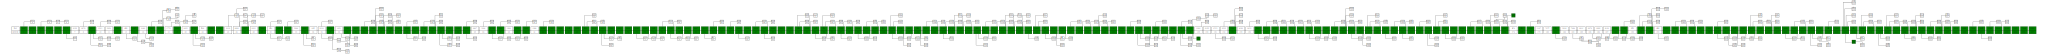

In [21]:
TRIM_FORKS = 0

# fork_paths = [[y] for y in df_leafs['HASH']]
# df_roots.apply(lambda row : fork_paths.extend(nx.all_simple_paths(forks_nx, row['HASH'], list(df_leafs['HASH']))), axis = 1)
# fork_paths_longer_than = paths_longer_than(fork_paths, MIN_FORK_LENGTH)
# nodes_in_forks_longer_than = nodes_in_paths(fork_paths_longer_than)
# df_trimmed = df.query('HASH in @nodes_in_forks_longer_than or HASH in @df_mainchain['HASH']')

df_trimmed = trim_chain(df, TRIM_FORKS)
# display(df_trimmed)

bc = create_digraph(df)
bc_trimmed = create_digraph(df_trimmed)

# Do something cool? Idk, for example mainchain in blue or make it bigger
df_trimmed.query("HASH in @df_mainchain['HASH']").apply(lambda row : bc_trimmed.node(row['HASH'], height='0.7', width='0.7'), axis = 1)
bc_trimmed.node(genesis, height='0.7', width='0.7')

# Do something cool? Idk, for example color blocks sealed by prefered sealer in green. 
df_trimmed.query('DIFF==2').apply(lambda row : bc_trimmed.node(row['HASH'], style='filled', fillcolor='green'), axis = 1)

# Do something cool? Idk, for example try to make mainchain at same level
df_trimmed.query("HASH in @df_mainchain['HASH']").apply(lambda row : bc_trimmed.node(row['HASH'], group='main'), axis = 1)
bc_trimmed.node(genesis, group='main')


# # Do something cool? Idk, make all black for mini-plot
# df_trimmed.apply(lambda row : bc_trimmed.node(row['HASH'], style='filled', fillcolor='black'), axis = 1)
# bc_trimmed.node(genesis, style='filled', fillcolor='black')

# # Do something cool? Idk, for example try to keep all forks at same level (slow!)
# df_trimmed.query('HASH in @nodes_in_forks_longer_than').apply(lambda row : bc_trimmed.node(row['HASH'], group='forks'), axis = 1)

# Save plot
bc_trimmed.render('plots/blockchain', format='png', view=True)
bc_trimmed

## Working Income VS Staking Income

In [ ]:
display(EXP_drop)
EXP = EXP_drop.value

# Generate the dataframe
df = create_df(EXP, 'collection')
df = get_param_df(df, 'generic', 'num_robots', alias = 'Robots')


# REP = ['002']
# df = df.query("REP in @REP")

# Plot options
XX = 'TIME_M'
YY = [str(x) for x in range(1,int(df['Robots'].unique())+1)]
yl = 'Token Balance'
fs = hlwidth

# Process the data
df['SUM'] = df[YY].sum(axis=1)
df['TIME_M'] = df['TIME']/60

# Create plot
ax = plt.axes()
# fig,ax = plt.subplots(1,1,figsize=fs) 
# df.set_index([XX]).groupby(['ID','EXP','REP'])[YY].plot(ax=ax)
df.set_index([XX]).groupby(['REP'])['1'].plot(ax=ax)

# Edit plot 
plt.suptitle('')
ax.xaxis.grid(False)
ax.yaxis.grid(True, linestyle = '--')

ax.set_xlim(xmin=0, xmax=15)
ax.set_ylabel(yl)
ax.set_title('')   

# Save plot
# plt.gcf().tight_layout()
# plt.savefig("plots/experiment_"+EXP+"/storage_bp_%s_%s.png" % (XX,YY), bbox_inches='tight', dpi=600)
plt.show()